In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

 Setting paths

In [2]:
import sys
import os

# --- CONFIGURATION ---
# FOLDER_NAME = "Eval-Foundation-Models-DiabeticRetinopathy-Grading"

# 1. Define the Main Project Base (The parent of both src and datasets)
# PROJECT_BASE_PATH = os.path.join("/content/drive/MyDrive", FOLDER_NAME)

# 2. Define the specific sub-paths
SRC_PATH = "D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/src"
DATA_DIR = "D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/datasets"

# --- SETUP ---
if os.path.exists(SRC_PATH):
    # Add 'src' to sys.path for imports
    if SRC_PATH not in sys.path:
        sys.path.append(SRC_PATH)

    # Change working directory to 'src' (keeps relative imports working internally)
    os.chdir(SRC_PATH)

    print(f"System Path Updated.")
    print(f"Working Directory: {os.getcwd()}")

    # Verify Datasets path
    if os.path.exists(DATA_DIR):
        print(f"Dataset Directory Found: {DATA_DIR}")
        # List the contents to confirm (IDRiD, DeepDR, etc.)
        print(f"Contents: {os.listdir(DATA_DIR)}")
    else:
        print(f"WARNING: Dataset path not found at: {DATA_DIR}")
else:
    print("SRC PATH not found")

System Path Updated.
Working Directory: D:\Zayaan\D_git\Eval-Foundation-Models-DiabeticRetinopathy-Grading\src
Dataset Directory Found: D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/datasets
Contents: ['DeepDRiD', 'IDRID', 'MESSIDOR', 'MFIDDR']


In [3]:
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121
!pip install timm==0.9.10
!pip install peft

Looking in indexes: https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement torch==2.4.1 (from versions: none)
ERROR: No matching distribution found for torch==2.4.1


In [4]:
from models.RETFound_MAE import models_vit
from models.RETFound_MAE.util import pos_embed
from timm.models.layers import trunc_normal_
import torchvision
from data_processing.dataloader import load_idrid_grading_labels
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader
from data_processing.dataset import CombinedDRDataSet
from utilities.utils import identity_transform, show_images, train_one_epoch, validate
from utilities.create_split import extract_for_split
from hparams.hparams import NUM_CLASSES,BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, NUM_WORKERS, DEVICE
import torch
from torch import nn
from torch import optim

c:\Users\zayaa\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Data initialization + creating test image dir split for MESSIDOR

In [ ]:
train_root_directories = {
    "DEEPDRID": f"{DATA_DIR}/DeepDRiD",
    "IDRID": f"{DATA_DIR}/IDRID",
    "MESSIDOR": f"{DATA_DIR}/MESSIDOR",
}

val_root_directories = {
    "DEEPDRID": f"{DATA_DIR}/DeepDRiD",
    "IDRID": f"{DATA_DIR}/IDRID",
    "MESSIDOR": f"{DATA_DIR}/MESSIDOR",
}

test_root_directories = {
    "DEEPDRID": f"{DATA_DIR}/DeepDRiD",
    "IDRID": f"{DATA_DIR}/IDRID",
    "MESSIDOR": f"{DATA_DIR}/MESSIDOR",
    "MFIDDR": f"{DATA_DIR}/MFIDDR", # only use for test if necessary
}

MESSIDOR_BASE_PATH = train_root_directories["MESSIDOR"]
# The SOURCE directory containing the images you want to split (80% will remain here for training):
# SOURCE_DIR = os.path.join(MESSIDOR_BASE_PATH, "messidor-2", "messidor-2", "preprocess")
# # The DESTINATION directory where the 20% test images will be moved:
# DESTINATION_DIR = os.path.join(MESSIDOR_BASE_PATH, "messidor-2", "messidor-2", "test")

# # ONLY SUPPOSED TO RUN ONCE

# TEST_FRACTION = 0.2
# print("Starting Data Split for MESSIDOR...")
# extract_for_split(SOURCE_DIR, DESTINATION_DIR, TEST_FRACTION)
# print("MESSIDOR split complete.")

Starting Data Split for MESSIDOR...
Found 1744 total images.
Calculating test size as 20% (348 images).
Destination folder 'D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/datasets/MESSIDOR\messidor-2\messidor-2\test' ensured.
Successfully copied 348 images to 'D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/datasets/MESSIDOR\messidor-2\messidor-2\test'.
MESSIDOR split complete.


Creating validation image dir split for IDRID and MESSIDOR (to only run once)

In [ ]:
# # for IDRID
# IDRID_BASE_PATH = train_root_directories["IDRID"]

# IDRID_TRAIN_SOURCE_DIR = os.path.join(IDRID_BASE_PATH, "B-Disease-Grading", "Disease-Grading", "1-Original-Images", "Training_Set")
# IDRID_VAL_DESTINATION_DIR = os.path.join(IDRID_BASE_PATH, "B-Disease-Grading", "Disease-Grading", "1-Original-Images", "Validation_Set")

# # for MESSIDOR
# MESSIDOR_TRAIN_SOURCE_DIR = os.path.join(MESSIDOR_BASE_PATH, "messidor-2", "messidor-2", "preprocess")
# MESSIDOR_VAL_DESTINATION_DIR = os.path.join(MESSIDOR_BASE_PATH, "messidor-2", "messidor-2", "validation")

# # only supposed to run once

# VAL_FRACTION = 0.1

# print("Starting Data Split for IDRID...")
# extract_for_split(IDRID_TRAIN_SOURCE_DIR, IDRID_VAL_DESTINATION_DIR, VAL_FRACTION)
# print("IDRID -> validation split complete.")

# print("Starting Data Split for MESSIDOR...")
# extract_for_split(MESSIDOR_TRAIN_SOURCE_DIR, MESSIDOR_VAL_DESTINATION_DIR, VAL_FRACTION)
# print("MESSIDOR -> validation split complete.")

Starting Data Split for IDRID...
Found 413 total images.
Calculating test size as 10% (41 images).
Destination folder 'D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/datasets/IDRID\B-Disease-Grading\Disease-Grading\1-Original-Images\Validation_Set' ensured.
Successfully copied 41 images to 'D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/datasets/IDRID\B-Disease-Grading\Disease-Grading\1-Original-Images\Validation_Set'.
IDRID -> validation split complete.
Starting Data Split for MESSIDOR...
Found 1396 total images.
Calculating test size as 10% (139 images).
Destination folder 'D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/datasets/MESSIDOR\messidor-2\messidor-2\validation' ensured.
Successfully copied 139 images to 'D:/Zayaan/D_git/Eval-Foundation-Models-DiabeticRetinopathy-Grading/datasets/MESSIDOR\messidor-2\messidor-2\validation'.
MESSIDOR -> validation split complete.


In [7]:
train_transformations = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

validation_transformations = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transformations = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

train_dataset = CombinedDRDataSet(root_directories=train_root_directories, split="train", img_transform=train_transformations, label_transform=identity_transform)
validation_dataset = CombinedDRDataSet(root_directories=val_root_directories, split="val", img_transform=validation_transformations, label_transform=identity_transform)
test_dataset = CombinedDRDataSet(root_directories=test_root_directories, split="test", img_transform=test_transformations)


print("Labels", train_dataset.get_labels())

# loading csv_paths (removed MFIDDR as too little samples , but possibly can use in testing)
train_csv_paths = {
    "IDRID": f"{train_root_directories['IDRID']}/B-Disease-Grading/Disease-Grading/2-Groundtruths/IDRiD_Disease_Grading_Training_Labels.csv",
    "DEEPDRID": f"{train_root_directories['DEEPDRID']}/regular_fundus_images/regular-fundus-training/regular-fundus-training.csv",
    "MESSIDOR": f"{train_root_directories['MESSIDOR']}/messidor_data.csv",
}

val_csv_paths = {
    "IDRID": f"{val_root_directories['IDRID']}/B-Disease-Grading/Disease-Grading/2-Groundtruths/IDRiD_Disease_Grading_Training_Labels.csv",
    "DEEPDRID": f"{val_root_directories['DEEPDRID']}/regular_fundus_images/regular-fundus-validation/regular-fundus-validation.csv",
    "MESSIDOR": f"{val_root_directories['MESSIDOR']}/messidor_data.csv",
}

# test_csv_paths = {
#     "IDRID": f"{root_directories['IDRID']}/B-Disease-Grading/Disease-Grading/2-Groundtruths/IDRiD_Disease_Grading_Testing_Labels.csv",
#     "DEEPDRID": f"{root_directories['DEEPDRID']}/regular_fundus_images/regular-fundus-validation/regular-fundus-validation.csv",
#     "MFIDDR": f"{root_directories['MFIDDR']}/sample/test_fourpic_label.csv"
# }

train_labels = train_dataset.load_labels_from_csv(train_csv_paths)
validation_labels = validation_dataset.load_labels_from_csv(val_csv_paths)
# test_labels = test_dataset.load_labels_from_csv(test_csv_paths)
# train_dataset.load_labels_from_csv(test_csv_paths)


print("TRAIN DATASET LENGTH:", train_dataset.__len__()) # 11/11/25 len is 0 for both hence there is error in data preprocessing
print("VALIDATION DATASET LENGTH:", validation_dataset.__len__())
# print("TEST DATASET LENGTH:", test_dataset.__len__())



# printing dataset statistics
print("Training Set Statistics:")
print(train_dataset.get_dataset_statistics())

print("\n\n")

print("Validation Set Statistics:")
print(validation_dataset.get_dataset_statistics())

# print()

# print("Test Set Statistics:")
# print(test_dataset.get_dataset_statistics())


# print("\nTest Set Statistics:")
# print(test_dataset.get_dataset_statistics())

# --- FIX: Set num_workers=0 to prevent freezing on Drive ---
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

print(train_loader.batch_size)


validation_loader = DataLoader(
    validation_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

print(validation_loader.batch_size)

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=32,
#     shuffle=False,
#     num_workers=4
# )


print(f"Train loader: {train_loader}")
print("Validation loader: {validation_loader}")

# checking inside dataset
# for idx in range(len(train_dataset)):
#     image, label, metadata = train_dataset[idx]
#     print(f"Image: {image} -- Label: {label} -- Metadata: {metadata}")

train_dataset_length = len(train_dataset)
print("TRAIN total samples: ", train_dataset_length)


validation_dataset_length = len(validation_dataset)
print("VALIDATION total samples: ", validation_dataset_length)

# show_images(train_dataset, train_labels, num_images=60, start_idx=0)

# mfiddr -> idrid -> deepdrid
# 413 idrid
# 1661 total

print(f"\nTrain batches: {len(train_loader)}")
print(f"\nValidation batches: {len(validation_loader)}")
# print(f"Test batches: {len(test_loader)}")



IDRID: D:\Zayaan\D_git\Eval-Foundation-Models-DiabeticRetinopathy-Grading\datasets\IDRID
IDRID exists: True

DEEPDRID_root: D:\Zayaan\D_git\Eval-Foundation-Models-DiabeticRetinopathy-Grading\datasets\DeepDRiD
DEEPDRID_root exists: True
Looking for images in: D:\Zayaan\D_git\Eval-Foundation-Models-DiabeticRetinopathy-Grading\datasets\DeepDRiD\regular_fundus_images\regular-fundus-training\Images
Directory exists: True

MESSIDOR_ROOT: D:\Zayaan\D_git\Eval-Foundation-Models-DiabeticRetinopathy-Grading\datasets\MESSIDOR
MESSIDOR_ROOT exists: True

IDRID: D:\Zayaan\D_git\Eval-Foundation-Models-DiabeticRetinopathy-Grading\datasets\IDRID
IDRID exists: True

DEEPDRID_root: D:\Zayaan\D_git\Eval-Foundation-Models-DiabeticRetinopathy-Grading\datasets\DeepDRiD
DEEPDRID_root exists: True
Looking for images in: D:\Zayaan\D_git\Eval-Foundation-Models-DiabeticRetinopathy-Grading\datasets\DeepDRiD\regular_fundus_images\regular-fundus-validation\Images
Directory exists: True

MESSIDOR_ROOT: D:\Zayaan\D_

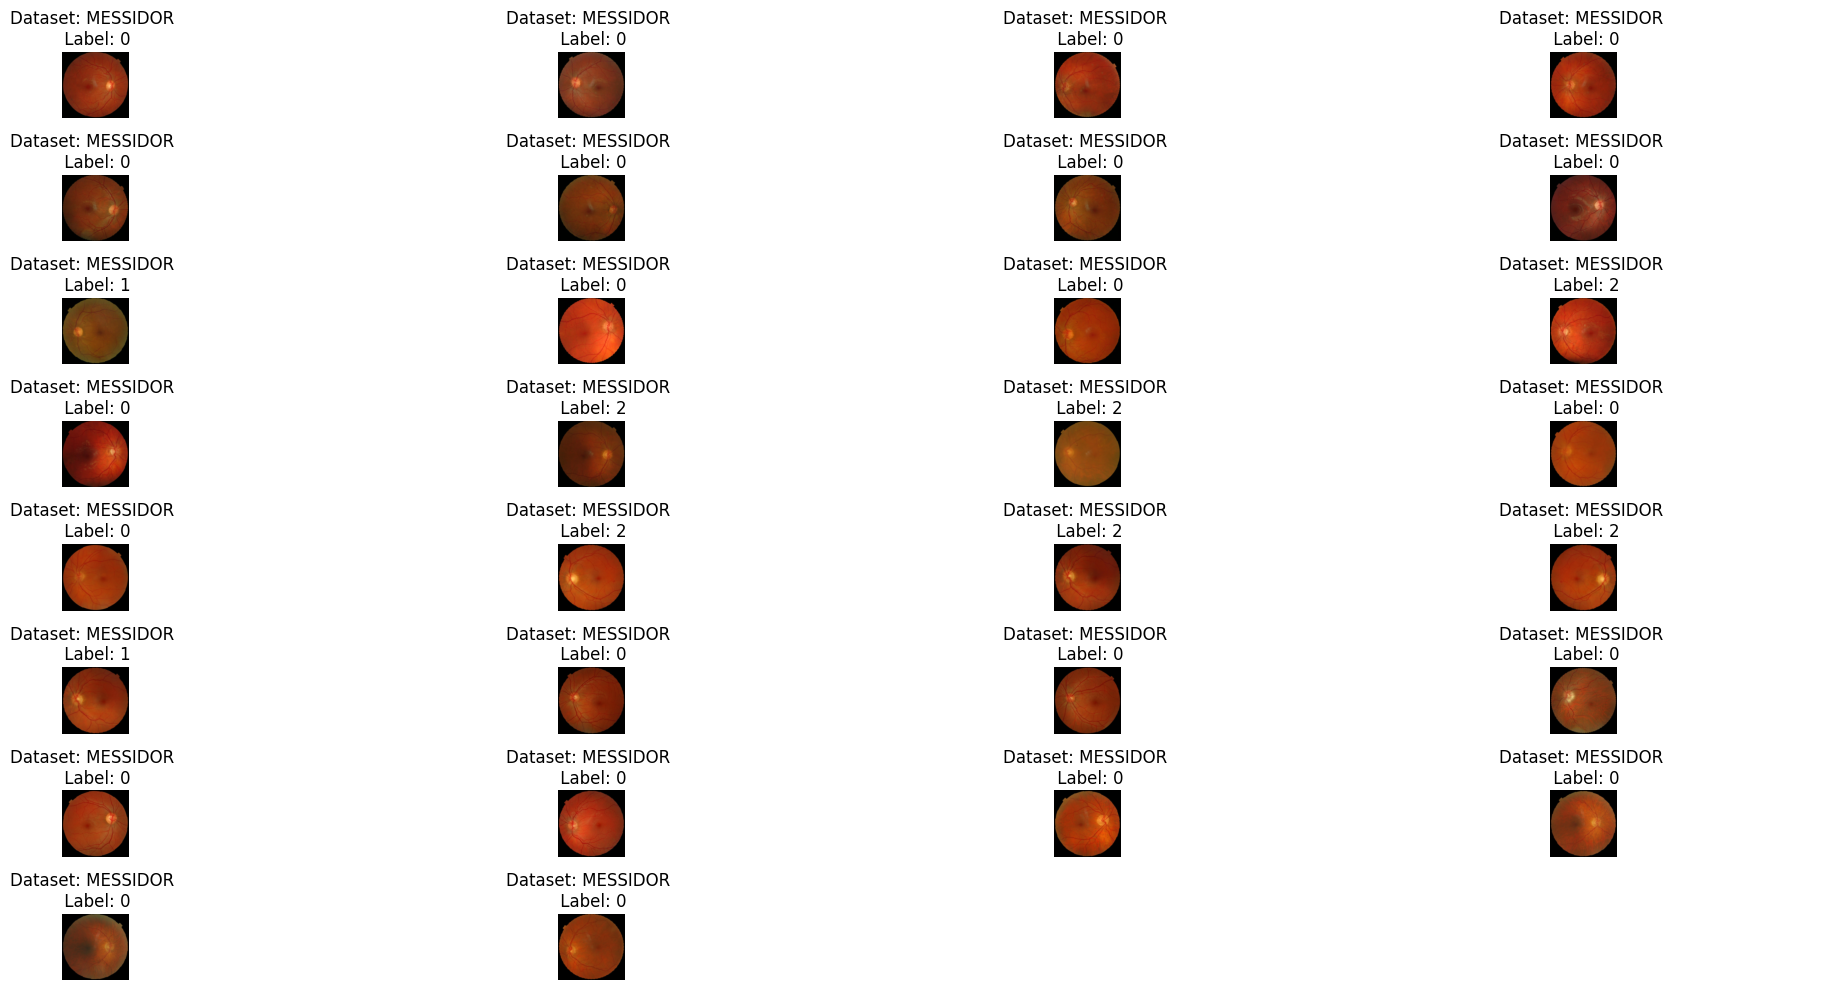

In [8]:
show_images(train_dataset, train_labels, num_images=30, start_idx=len(train_dataset)-200)

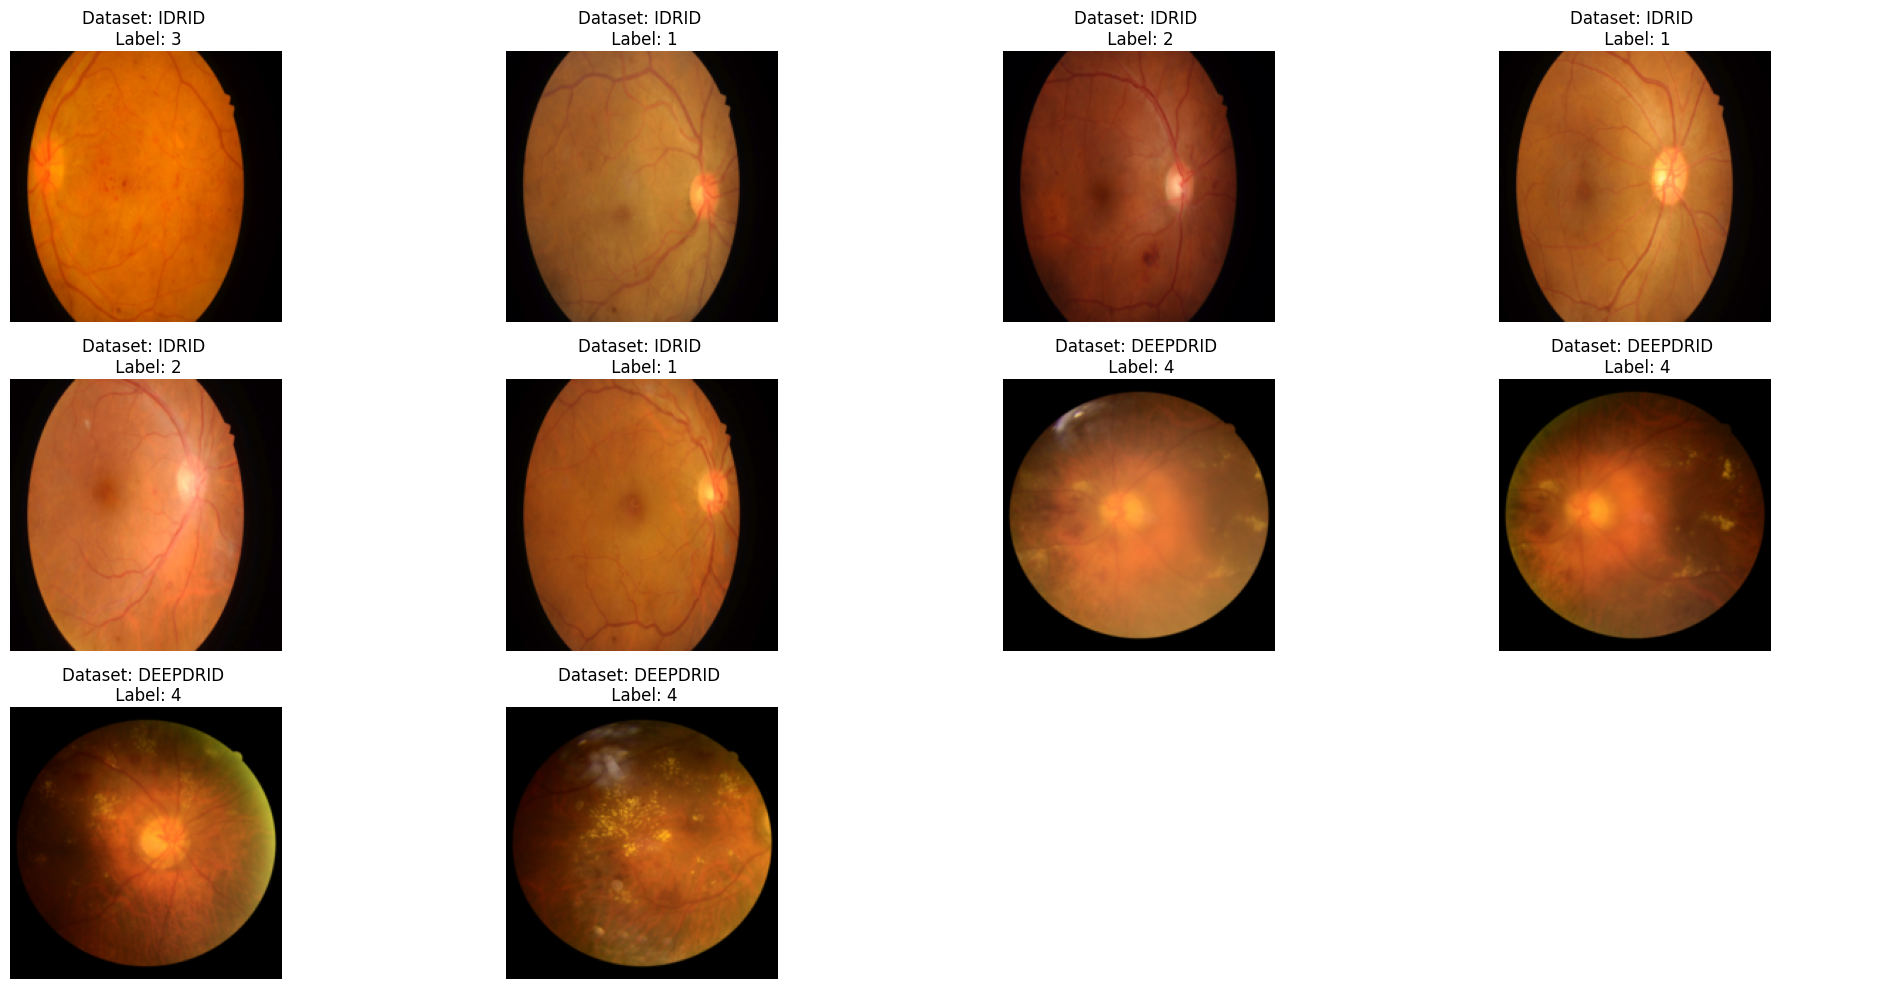

In [9]:
show_images(validation_dataset, train_labels, num_images=10, start_idx=35)

RETFound model intialization

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

# show_images(train_dataset, train_labels, num_images=60, start_idx=0)

# mfiddr -> idrid -> deepdrid
# 413 idrid
# 1661 total

print(f"\nTrain batches: {len(train_loader)}")
# print(f"Test batches: {len(test_loader)}")


print("\n" + "="*50)
print("Initializing RETFound Model")
print("="*50)

model = models_vit.__dict__["vit_large_patch16"](
    num_classes=NUM_CLASSES,
    drop_path_rate=0.2,
    global_pool=True
)

checkpoint_path = f"{SRC_PATH}/models/RETFound_MAE/weights/RETFound_cfp_weights.pth"
print(f"Loading pretrained weights from: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
checkpoint_model = checkpoint["model"]
state_dict = model.state_dict()

# removing head weights (as they dont match number of classes for severity grading 0-4)
for k in ["head.weight", "head.bias"]:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint (shape mismatch)")
        del checkpoint_model[k]

pos_embed.interpolate_pos_embed(model, checkpoint_model)

# Loading the weights
msg = model.load_state_dict(checkpoint_model, strict=False)
print(f"Missing keys: {msg.missing_keys}")
print(f"Unexpected keys: {msg.unexpected_keys}")

# verifying we're only missing the classification head
assert set(msg.missing_keys) == {"head.weight", "head.bias", "fc_norm.weight", "fc_norm.bias"}

# initializing the new classification head
trunc_normal_(model.head.weight, std=2e-5)

print("\nWrapping model with LoRA adapters...")
peft_config = LoraConfig(
    r=16,                  # rank
    lora_alpha=16,
    target_modules=["qkv"], # target attention layers in ViT
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["head", "fc_norm"] # keeping classification head and norm trainable
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

model = model.to(DEVICE)

# param count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


Training

In [ ]:
# Training
print("\n" + "="*50)
print("Starting Training")
print("="*50)

best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE, epoch
    )

    # Validate
    # val_loss, val_acc = validate(model, test_loader, criterion)

    # lr update
    scheduler.step()

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    # print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% ")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Saving best model
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     print(f"  ✓ New best validation accuracy: {val_acc:.2f}%")
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'val_acc': val_acc,
    #         'val_loss': val_loss,
    #     }, 'best_retfound_model.pth')

print("\n" + "="*50)
print("Training Complete!")
print("="*50)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")